In [78]:
import numpy as np
import torch as pt
from matplotlib import pyplot as plt
import sys
from pathlib import Path
import src.constants as constants
import sys
from display_data.data_acquisition_shadow import derandomized_classical_shadow, randomized_classical_shadow
from display_data.prediction_shadow import estimate_exp
sys.path.append(Path('../src'))
from src.mps import MPS
from src.tfim_hamiltonian_open_fermion import TfimHamiltonianOpenFermion
from src.mps_quantum_state import MPSQuantumState

In [79]:
# this function converts the stored measurement outcomes to the correct shape needed for the shadow prediction
def conversion_to_prediction_shadow_dict_shape(measurement_procedure, measurement_index, qubit_num):
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(qubit_num))
    strs = to_str_func(measurement_index)
    dirac_rep = np.zeros(list(measurement_index.shape) + [qubit_num], dtype=np.int8)
    for bit_ix in range(0, qubit_num):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')
        dirac_rep[...,bit_ix] = fetch_bit_func(strs).astype("int8")
    measurement_array = np.where(dirac_rep == 1, -1, dirac_rep)
    measurement_array = np.where(dirac_rep == 0, 1, measurement_array)
    measurement = np.dstack((measurement_procedure, np.array(measurement_array, dtype=int)))
    return measurement

In [82]:
ratio_h_j = 1.0
qubit_num = 14
save_direc_groundstate = Path('data/Diagonal_hamiltonian/groundstate_dict.npy')
ground_state_dict = np.load(save_direc_groundstate, allow_pickle='TRUE')
ground_state_dict = ground_state_dict.item()
ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)]
mps = MPS.from_state_vector(qubit_num, ground_state)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)

In [83]:
save_direc_eigs = Path('data/Diagonal_hamiltonian/eigenvalues_first_three_dict.npy')
energy_dict = np.load(save_direc_eigs, allow_pickle=True)
energy_dict = energy_dict.item()
energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(ratio_h_j)][0]
print(energy_brute)

-17.471004054732024


## Comparison of modified shadows vs original shadows

In [66]:
# 100s for one batch
#modified shadows
qubit_num = 14
batches = 1
some_ratios = np.array([0.1, 1.0])
num_of_measurements = np.array([10, 20, 50, 100, 140])
num_of_measurements_per_rot = np.array([10, 20, 50, 100, 140])
meas_methods = ['randomized', 'derandomized']
rel_error_modified = np.zeros((np.size(num_of_measurements), batches, np.size(meas_methods), np.size(some_ratios)))
for s in range(np.size(some_ratios)):
    ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(some_ratios[s])]
    mps = MPS.from_state_vector(qubit_num, ground_state)
    mps.normalise()
    mps.orth_idx = 0
    mps.canonicalise(qubit_num - 1)
    for l in range(0,2):
        if meas_methods[l] == 'derandomized':
            num_of_measurements = 2 * np.ones(np.size(num_of_measurements))
            num_of_measurements_per_rot = (num_of_measurements * num_of_measurements_per_rot) / 2
        for b in range(batches):
            print('starting batch ' + str(b))
            for i in range(np.size(num_of_measurements)):
                observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
                meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(int(num_of_measurements[i]), int(num_of_measurements_per_rot[i]), meas_methods[l], observables)
                energies = pt.zeros(len(meas_outcomes))
                for n in range(len(meas_outcomes)):
                    probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
                    measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
                    energies[n] = TfimHamiltonianOpenFermion(qubit_num, some_ratios[s], 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_methods[l])
                energy = pt.mean(energies)
                energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(some_ratios[s])][0]
                rel_error_modified[i,b,l,s] = np.abs(energy - energy_brute) / np.abs(energy_brute)

starting batch 0
starting batch 0
starting batch 0
starting batch 0


In [10]:
#unmodified classical shadows
num_of_measurements = np.array([50, 100, 200, 300, 500, 700, 1000, 1500, 2000, 5000, 7000, 10000, 20000])
batches = 50
errors = np.zeros((batches, np.size(num_of_measurements), np.size(meas_methods), np.size(some_ratios)))
for s in range(0, np.size(some_ratios)):
    for l in range(0, 2):
        energy_shadow = np.zeros(np.size(num_of_measurements))
        energy_brute = energy_dict[str(1)]['periodic'][str(qubit_num)][str(some_ratios[s])][0] * np.ones(np.size(num_of_measurements))
        save_direc_procedure = Path('data/shadow_measurements/measurement_procedure_ratio_'+\
                              str(some_ratios[s])+'_qubit_num_'+str(qubit_num)+'_method_'+meas_methods[l]+'.npy')
        save_direc_index = Path('data/shadow_measurements/measurement_index_ratio_'+\
                              str(some_ratios[s])+'_qubit_num_'+str(qubit_num)+'_method_'+meas_methods[l]+'.npy')
        measurement_procedure = np.lib.format.open_memmap(save_direc_procedure, dtype=np.str_, mode='r')
        measurement_index = np.lib.format.open_memmap(save_direc_index, dtype=np.int32, mode='r')
        for k in range(0, batches):
            for j in range(0, np.size(num_of_measurements)):
                measurements = conversion_to_prediction_shadow_dict_shape(measurement_procedure[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]],
                                                                          measurement_index[k*num_of_measurements[j]:(k+1)*num_of_measurements[j]], qubit_num)
                energy_shadow[j] = TfimHamiltonianOpenFermion(qubit_num,some_ratios[s], 1, 'periodic').energy_shadow(None,num_of_measurements[j],meas_methods[l], measurements)
            errors[k,:, l, s] = np.abs(energy_shadow - energy_brute) / np.abs(energy_brute)

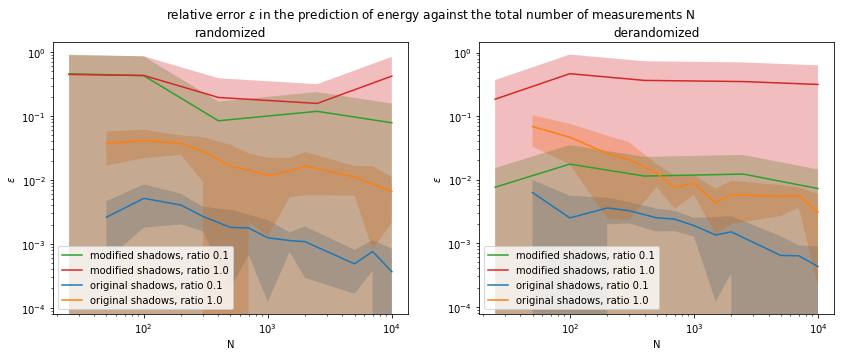

In [11]:
num_of_measurements = np.array([50, 100, 200, 300, 500, 700, 1000, 1500, 2000, 5000, 7000, 10000, 20000])
fig, axs = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(14)
fig.suptitle('relative error $\epsilon$ in the prediction of energy against the total number of measurements N, ' + str(qubit_num) + ' qubits')
error_mean_orig = np.mean(errors, axis=0)
error_std_orig = np.std(errors, axis=0)
for s in range(np.size(some_ratios)):
    for l in range(0,2):
        axs[l].errorbar(num_of_measurements, error_mean_orig[:,l, s], label = 'original shadows, ratio ' + str(some_ratios[s]))
        axs[l].fill_between(num_of_measurements, error_mean_orig[:,l, s] - error_std_orig[:,l, s], error_mean_orig[:,l,s] + error_std_orig[:,l,s], alpha = 0.3)

num_of_measurements = np.array([10, 20, 50, 100, 140])
num_of_measurements_per_rot = np.array([10, 20, 50, 100, 140])
rel_error_mean = np.mean(rel_error_modified, axis=1)
rel_error_std = np.mean(rel_error_modified, axis=1)
for s in range(np.size(some_ratios)):
    for l in range(0,2):
        axs[l].plot(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,l, s], label='modified shadows, ratio ' + str(some_ratios[s]))
        axs[l].fill_between(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,l, s] - rel_error_std[:,l, s], rel_error_mean[:,l,s] + rel_error_std[:,l,s], alpha=0.3)
        axs[l].set(yscale='log', xscale='log', xlabel='N', ylabel='$\epsilon$')
        axs[l].set_title(meas_methods[l])
        axs[l].legend()

In [12]:
# now we look at the performance of derandomized shadows alone
#modified shadows
qubit_num = 14
batches = 2
some_ratios = np.array([0.1, 1.0])
num_of_measurements_per_rot = np.array([10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
num_of_measurements = 2 * np.ones(np.size(num_of_measurements_per_rot))
meas_methods = ['derandomized']
rel_error_modified = np.zeros((np.size(num_of_measurements), batches, np.size(meas_methods), np.size(some_ratios)))
for s in range(np.size(some_ratios)):
    ground_state = ground_state_dict[str(1)]['open'][str(qubit_num)][str(some_ratios[s])]
    mps = MPS.from_state_vector(qubit_num, ground_state)
    mps.normalise()
    mps.orth_idx = 0
    mps.canonicalise(qubit_num - 1)
    for l in range(0,1):
        for b in range(batches):
            print('starting batch ' + str(b))
            for i in range(np.size(num_of_measurements)):
                observables = TfimHamiltonianOpenFermion(qubit_num, some_ratios[s], 1, 'open').observables_for_energy_estimation()
                meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(int(num_of_measurements[i]), int(num_of_measurements_per_rot[i]), meas_methods[l], observables)
                energies = pt.zeros(len(meas_outcomes))
                for n in range(len(meas_outcomes)):
                    probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
                    measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
                    energies[n] = TfimHamiltonianOpenFermion(qubit_num, some_ratios[s], 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_methods[l])
                energy = pt.mean(energies)
                energy_brute = energy_dict[str(1)]['open'][str(qubit_num)][str(some_ratios[s])][0]
                rel_error_modified[i,b,l,s] = np.abs(energy - energy_brute) / np.abs(energy_brute)

starting batch 0
starting batch 1
starting batch 0
starting batch 1


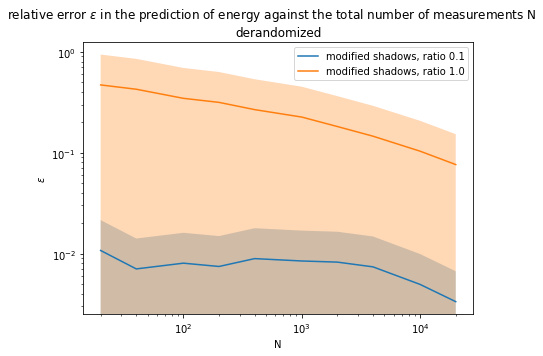

In [13]:
rel_error_mean = np.mean(rel_error_modified, axis=1)
rel_error_std = np.mean(rel_error_modified, axis=1)
fig, axs = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(7)
fig.suptitle('relative error $\epsilon$ in the prediction of energy against the total number of measurements N')
for s in range(np.size(some_ratios)):
    for l in range(0,1):
        axs.plot(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,l, s], label='modified shadows, ratio ' + str(some_ratios[s]))
        axs.fill_between(num_of_measurements*num_of_measurements_per_rot, rel_error_mean[:,l, s] - rel_error_std[:,l, s], rel_error_mean[:,l,s] + rel_error_std[:,l,s], alpha=0.3)
        axs.set(yscale='log', xscale='log', xlabel='N', ylabel='$\epsilon$')
        axs.set_title(meas_methods[l])
        axs.legend()

## Gradient Estimation with Classical Shadows

In [67]:
# now we try to estimate the gradient directly by contracting the mps with hamiltonian
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [68]:
# 6min per batch
# now we estimate the gradient by using the derandomized classical shadows
num_meas_bases = 2
num_of_measurements_per_rot = np.array([10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 1e4, 2e4, 5e4])
batches = 1
some_ratios = np.array([0.1, 1.0])
state_categories = np.array(['random']) # could use 'ground' as well but gradient vanishes there
errors = np.zeros((np.size(num_of_measurements_per_rot), batches, np.size(some_ratios), np.size(state_categories)))

for s in range(np.size(state_categories)):
    for h in range(np.size(some_ratios)):
        if state_categories[s] == 'random':
            param_vec_brute = random_param_vec.clone().detach()
            param_vec_brute.requires_grad_(True)
            mps_brute = MPS.from_tensor_list(tensor_liste_rand)
            mps_brute.from_param_vec(param_vec=param_vec_brute)
        if state_categories[s] == 'ground':
            param_vec_brute = ground_state_dict[str(1)]['open'][str(qubit_num)][str(some_ratios[h])].clone().detach()
            param_vec_brute.requires_grad_(True)
            mps_brute = MPS.from_state_vector(qubit_num, param_vec_brute)

        mps_brute.normalise()
        mps_brute.orth_idx = 0
        mps_brute.canonicalise(qubit_num - 1)
        psi = mps_brute.to_state_vector()
        hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').to_matrix().todense())
        energy_bf = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
        energy_bf.backward()

        for b in range(0, batches):
            print('starting batch ' + str(b))
            for j in range(np.size(num_of_measurements_per_rot)):
                if state_categories[s] == 'random':
                    param_vec_shadow = random_param_vec.clone().detach()
                    param_vec_shadow.requires_grad_(True)
                    mps = MPS.from_tensor_list(tensor_liste_rand)
                    mps.from_param_vec(param_vec=param_vec_shadow)
                if state_categories[s] == 'ground':
                    param_vec_shadow = ground_state_dict[str(1)]['open'][str(qubit_num)][str(some_ratios[h])].clone().detach()
                    param_vec_shadow.requires_grad_(True)
                    mps = MPS.from_state_vector(qubit_num, param_vec_shadow)

                mps.normalise()
                mps.orth_idx = 0
                mps.canonicalise(qubit_num - 1)
                observables = TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').observables_for_energy_estimation()
                meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(int(num_meas_bases), int(num_of_measurements_per_rot[j]), 'derandomized', observables)
                energies = pt.zeros(len(meas_outcomes))
                for n in range(len(meas_outcomes)):
                    probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
                    measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
                    energies[n] = TfimHamiltonianOpenFermion(qubit_num, some_ratios[h], 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, 'derandomized')
                energy_shadow = pt.mean(energies)
                energy_shadow.backward()
                errors[j,b,h,s] = pt.linalg.norm((param_vec_brute.grad - param_vec_shadow.grad) / pt.linalg.norm(param_vec_shadow.grad))

starting batch 0
starting batch 0


KeyboardInterrupt: 

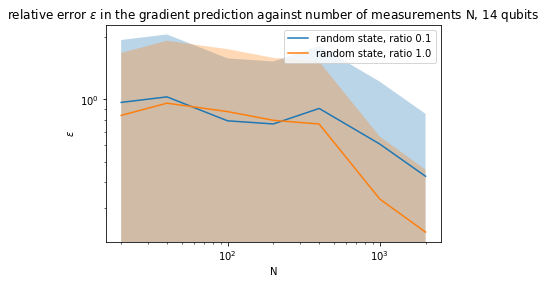

In [60]:
rel_error_mean = np.mean(errors, axis=1)
rel_error_std = np.mean(errors, axis=1)
for s in range(np.size(state_categories)):
    for h in range(np.size(some_ratios)):
        plt.plot(num_of_measurements_per_rot * num_meas_bases, rel_error_mean[:,h,s], label = state_categories[s] + ' state, ratio ' + str(some_ratios[h]))
        plt.fill_between(num_of_measurements_per_rot * num_meas_bases, rel_error_mean[:,h,s] - rel_error_std[:,h,s], rel_error_mean[:,h,s] + rel_error_std[:,h,s], alpha=0.3)
plt.title('relative error $\epsilon$ in the gradient prediction against number of measurements N, ' + str(qubit_num) + ' qubits')
plt.xlabel('N')
plt.ylabel('$\epsilon$')
plt.yscale('log')
plt.xscale('log')
plt.legend()

## Gradient Descent with Classical Shadows, comparison to other methods

In [75]:
# we do gradient descent with the exact hamiltonian contraction method and see whether we converge to the ground state
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [76]:
# doing gradient descent using brute force
step_num = 100
lr = 0.01
random_param_vec_brute = random_param_vec.clone().detach()
random_param_vec_brute.requires_grad_(True)
opt = pt.optim.Adam([random_param_vec_brute], lr=lr)

accuracy_brute = np.zeros(step_num)
for i in range(0, step_num):
    opt.zero_grad()
    mps.from_param_vec(param_vec = random_param_vec_brute)
    psi = mps.to_state_vector()
    hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
    energy = psi.conj() @ hamiltonian @ psi / (psi.conj() @ psi)
    energy.backward()
    accuracy_brute[i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
    opt.step()
    print('progress: ' + str(i+1) + ' / ' + str(step_num))

progress: 1 / 100
progress: 2 / 100
progress: 3 / 100
progress: 4 / 100
progress: 5 / 100
progress: 6 / 100
progress: 7 / 100
progress: 8 / 100
progress: 9 / 100
progress: 10 / 100
progress: 11 / 100
progress: 12 / 100
progress: 13 / 100
progress: 14 / 100
progress: 15 / 100
progress: 16 / 100
progress: 17 / 100
progress: 18 / 100
progress: 19 / 100
progress: 20 / 100
progress: 21 / 100
progress: 22 / 100
progress: 23 / 100
progress: 24 / 100
progress: 25 / 100
progress: 26 / 100
progress: 27 / 100
progress: 28 / 100
progress: 29 / 100
progress: 30 / 100
progress: 31 / 100
progress: 32 / 100
progress: 33 / 100
progress: 34 / 100
progress: 35 / 100
progress: 36 / 100
progress: 37 / 100
progress: 38 / 100
progress: 39 / 100
progress: 40 / 100
progress: 41 / 100
progress: 42 / 100
progress: 43 / 100
progress: 44 / 100
progress: 45 / 100
progress: 46 / 100
progress: 47 / 100
progress: 48 / 100
progress: 49 / 100
progress: 50 / 100
progress: 51 / 100
progress: 52 / 100
progress: 53 / 100
pr

KeyboardInterrupt: 

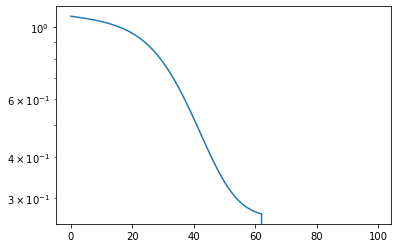

In [77]:
plt.plot(np.arange(0, step_num), accuracy_brute)
plt.yscale('log')

In [84]:
# now we try to estimate the gradient with classical shadows
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand)
mps.normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [ ]:
# doing gradient descent using shadows
step_num = 150
lr = 0.01
num_of_measurements = 2
num_of_measurements_per_rot = np.array([500, 1000, 5000])
meas_method = 'derandomized'
num_unique_ind_shadow = np.zeros((2, np.size(num_of_measurements_per_rot), step_num))
accuracy = np.zeros((np.size(num_of_measurements_per_rot), step_num))
for num in range(np.size(num_of_measurements_per_rot)):
    random_param_vec_shadow = random_param_vec.clone().detach()
    random_param_vec_shadow.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_shadow], lr=lr)
    print('starting meas_num ' + str(num_of_measurements_per_rot[num]))
    for i in range(step_num):
        opt.zero_grad()
        mps.from_param_vec(param_vec=random_param_vec_shadow)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            observables = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').observables_for_energy_estimation()
            meas_outcomes, meas_procedure, probs = MPSQuantumState(qubit_num, mps).measurement_shadow(num_of_measurements, num_of_measurements_per_rot[num], meas_method, observables)
            num_unique_ind_shadow[0, num, i] = len(meas_outcomes[0])
            num_unique_ind_shadow[1, num, i] = len(meas_outcomes[1])
        energies = pt.zeros(len(meas_outcomes))
        for n in range(len(meas_outcomes)):
            probs_direct = MPSQuantumState(qubit_num, mps).rotate_pauli(meas_procedure[n]).prob(pt.tensor(meas_outcomes[n]))
            measurements = conversion_to_prediction_shadow_dict_shape([meas_procedure[n]]*len(meas_outcomes[n]), np.array(meas_outcomes[n]), qubit_num)
            energies[n] = TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').energy_shadow_mps_modified(measurements, probs_direct, meas_method)
        energy_shadow = pt.mean(energies)
        energy_shadow.backward()
        accuracy[num, i] = np.abs(energy_shadow.detach() - energy_brute) / np.abs(energy_brute)
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))
        print(f'loss = {accuracy[num, i]}')

starting meas_num 500
progress: 1 / 150
loss = 1.8179197311401367
progress: 2 / 150
loss = 1.8148512840270996
progress: 3 / 150
loss = 1.8092185258865356
progress: 4 / 150
loss = 1.769918441772461
progress: 5 / 150
loss = 1.7906006574630737
progress: 6 / 150
loss = 1.784463882446289
progress: 7 / 150
loss = 1.7639082670211792
progress: 8 / 150
loss = 1.7459132671356201
progress: 9 / 150
loss = 1.7522239685058594
progress: 10 / 150
loss = 1.7368332147598267
progress: 11 / 150
loss = 1.7127209901809692
progress: 12 / 150
loss = 1.7084425687789917
progress: 13 / 150
loss = 1.7118303775787354
progress: 14 / 150
loss = 1.6876283884048462
progress: 15 / 150
loss = 1.6632100343704224
progress: 16 / 150
loss = 1.6485003232955933
progress: 17 / 150
loss = 1.6432591676712036
progress: 18 / 150
loss = 1.605363368988037
progress: 19 / 150
loss = 1.5968207120895386
progress: 20 / 150
loss = 1.5664012432098389
progress: 21 / 150
loss = 1.55411958694458
progress: 22 / 150
loss = 1.5488923788070679
pr

In [ ]:
plt.figure(figsize=(7,5))
for num in range(np.size(num_of_measurements_per_rot)):
    plt.plot(np.arange(0, step_num), accuracy[num, :], label='shadow, samples: ' + str(num_of_measurements_per_rot[num]))
plt.plot(np.arange(0, step_num), accuracy_brute, label='exact')
plt.title('relative error $\epsilon$ in the prediction of the ground state against number of iterations' + str(qubit_num) + ' qubits, ratio h/J = ' + str(ratio_h_j) )
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')
plt.legend()

Third approach to obtain the gradient:
1.) Measure in the computational basis and obtain indices
2.) obtain the exact amplitudes of these indices
3.) fill these amplitudes/indices into a quantum state
4.) renormalize the quantum state
5.) determine the energy via contraction with Hamiltonian
6.) backpropagation

In [26]:
#generate a random tensor list
bond_dim = 50
tensor_liste_rand = [pt.rand([1, 2, bond_dim], dtype=pt.cdouble)]
for idx in range(qubit_num - 2):
    tensor_liste_rand.append(pt.rand([bond_dim, 2, bond_dim], dtype=pt.cdouble))
tensor_liste_rand.append(pt.rand([bond_dim, 2, 1], dtype=pt.cdouble))
mps = MPS.from_tensor_list(tensor_liste_rand).normalise()
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
param_vec = mps.to_param_vec()
# we only needed this param vec to determine the size of the tensor
random_param_vec = pt.rand(param_vec.shape[0], dtype=pt.cdouble)

In [27]:
#sampling brute
step_num = 300
lr = 0.01
num_meas = np.array([1000])
num_unique_ind_brute = np.zeros((np.size(num_meas),step_num))

accuracy_brute_sample = np.zeros((np.size(num_meas), step_num))
for num in range(np.size(num_meas)):
    random_param_vec_brute_sample = random_param_vec.clone().detach()
    random_param_vec_brute_sample.requires_grad_(True)
    opt = pt.optim.Adam([random_param_vec_brute_sample], lr=lr)
    for i in range(step_num):
        if i>=150:
            num_meas[num] = 2000
        opt.zero_grad()
        mps.from_param_vec(param_vec = random_param_vec_brute_sample)
        mps.normalise()
        mps.orth_idx = 0
        mps.canonicalise(qubit_num - 1)
        with pt.no_grad():
            indices, probs = MPSQuantumState(qubit_num, mps).measure(num_meas[num])
            num_unique_ind_brute[num, i] = len(indices)
        ampl_direct = MPSQuantumState(qubit_num, mps).amplitude(pt.tensor(indices))
        psi = pt.zeros(2**qubit_num, dtype=pt.cdouble)
        psi[indices] = ampl_direct
        psi = psi / pt.linalg.norm(psi)
        hamiltonian = pt.from_numpy(TfimHamiltonianOpenFermion(qubit_num, ratio_h_j, 1, 'open').to_matrix().todense())
        energy = psi.conj() @ hamiltonian @ psi
        energy.backward()
        accuracy_brute_sample[num, i] = np.abs(energy.detach() - energy_brute) / np.abs(energy_brute)
        opt.step()
        print('progress: ' + str(i+1) + ' / ' + str(step_num))

progress: 1 / 300
progress: 2 / 300
progress: 3 / 300
progress: 4 / 300
progress: 5 / 300
progress: 6 / 300
progress: 7 / 300
progress: 8 / 300
progress: 9 / 300
progress: 10 / 300
progress: 11 / 300
progress: 12 / 300
progress: 13 / 300
progress: 14 / 300
progress: 15 / 300
progress: 16 / 300
progress: 17 / 300
progress: 18 / 300
progress: 19 / 300
progress: 20 / 300
progress: 21 / 300
progress: 22 / 300
progress: 23 / 300
progress: 24 / 300
progress: 25 / 300
progress: 26 / 300
progress: 27 / 300
progress: 28 / 300
progress: 29 / 300
progress: 30 / 300
progress: 31 / 300
progress: 32 / 300
progress: 33 / 300
progress: 34 / 300
progress: 35 / 300
progress: 36 / 300
progress: 37 / 300
progress: 38 / 300
progress: 39 / 300
progress: 40 / 300
progress: 41 / 300
progress: 42 / 300
progress: 43 / 300
progress: 44 / 300
progress: 45 / 300
progress: 46 / 300
progress: 47 / 300
progress: 48 / 300
progress: 49 / 300
progress: 50 / 300
progress: 51 / 300
progress: 52 / 300
progress: 53 / 300
pr

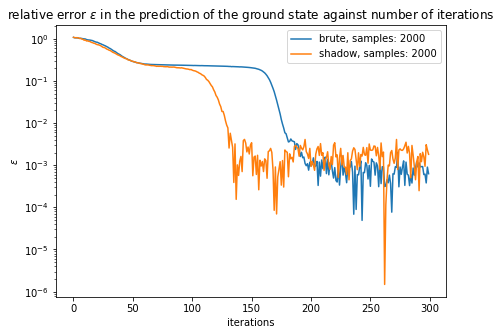

In [28]:
plt.figure(figsize=(7,5))
for num in range(np.size(num_meas)):
    plt.plot(np.arange(0, step_num), accuracy_brute_sample[num, :], label='brute, samples: ' + str(num_meas[num]))
    plt.plot(np.arange(0, step_num), accuracy[num, :], label='shadow, samples: ' + str(num_meas[num]))
plt.plot(np.arange(0, step_num), accuracy_brute, label='exact')
plt.title('relative error $\epsilon$ in the prediction of the ground state against number of iterations' + str(qubit_num) + ' qubits')
plt.yscale('log')
plt.xlabel('iterations')
plt.ylabel('$\epsilon$')
plt.legend()

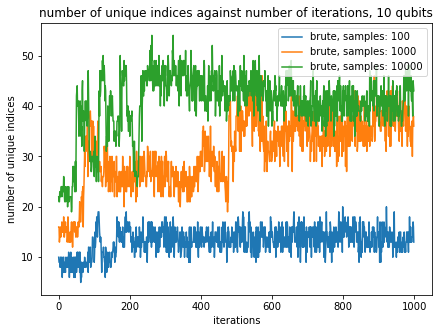

In [160]:
plt.figure(figsize=(7,5))
for num in range(np.size(num_meas)):
    plt.plot(np.arange(0, step_num), num_unique_ind_brute[num, :], label='brute, samples: ' + str(num_meas[num]))
    #plt.plot(np.arange(0, step_num), num_unique_ind_shadow[0, num, :], label='shadow X, samples: ' + str(num_meas[num]))
    #plt.plot(np.arange(0, step_num), num_unique_ind_shadow[1, num, :], label='shadow Z, samples: ' + str(num_meas[num]))
plt.xlabel('iterations')
plt.ylabel('number of unique indices')
plt.title('number of unique indices against number of iterations, ' + str(qubit_num) + ' qubits')
#plt.yscale('log')

plt.legend()

In [ ]:
samples = pt.tensor([7, 2**4, 15, 3])
coupling_mask = pt.tensor([31, 1])
samples = pt.unsqueeze(samples, 1)
samples = samples.expand(-1, coupling_mask.size()[0])
coupling_mask = pt.unsqueeze(coupling_mask, 0)
coupling_mask = coupling_mask.expand(samples.size()[0], -1)
basis_idx_new = pt.bitwise_xor(samples, coupling_mask)
phase_mask = coupling_mask
num_ones_y_z = pt.bitwise_and(samples, phase_mask)
mask = 2**pt.arange(2**5)
num_ones_y_z = pt.sum(num_ones_y_z.unsqueeze(-1).bitwise_and(mask).ne(0).byte(), dim=2)
num_y = pt.tensor([0, 1])
num_y = num_y.unsqueeze(0).expand(samples.size()[0], -1)
phases = 1j**num_y * (-1)**num_ones_y_z
print(phases)
print(basis_idx_new)


In [52]:
def local_energy(samples, coupling_mask, phase_mask, num_y, coeff):
    basis_idx_new = pt.bitwise_xor(samples.unsqueeze(1).expand(-1, coupling_mask.size()[0]), coupling_mask.unsqueeze(0).expand(samples.size()[0], -1))
    num_ones_y_z = pt.bitwise_and(samples.unsqueeze(1).expand(-1, phase_mask.size()[0]), phase_mask.unsqueeze(0).expand(samples.size()[0], -1))
    mask = 2**pt.arange(2**5)
    num_ones_y_z = pt.sum(num_ones_y_z.unsqueeze(-1).bitwise_and(mask).ne(0).byte(), dim=2)
    phases = 1j**num_y.unsqueeze(0).expand(samples.size()[0], -1) * (-1)**num_ones_y_z
    ampl_old = MPSQuantumState(qubit_num, mps).amplitude(samples)
    ampl_new = MPSQuantumState(qubit_num, mps).amplitude(basis_idx_new.reshape(pt.prod(pt.tensor(basis_idx_new.size()))))
    ampl_new = ampl_new.reshape((pt.tensor(basis_idx_new.size())[0],pt.tensor(basis_idx_new.size())[1]))
    exp_vals = ampl_new * phases
    e_loc = pt.einsum('ab,b->a', exp_vals, coeff)
    e_loc = e_loc / ampl_old
    return e_loc

In [53]:
# precomputations for TFIM
observables = TfimHamiltonianOpenFermion(qubit_num, 0.1, 1, 'open').observables_for_energy_estimation()
coupling_mask = pt.zeros(len(observables), dtype=pt.int)
phase_mask = pt.zeros(len(observables), dtype=pt.int)
num_y = pt.zeros(len(observables), dtype=pt.int)
coeff = pt.zeros(len(observables), dtype=pt.cdouble)
for i in range(len(observables)):
    for observable_1_loc in observables[i]:
        if observable_1_loc[0] == 'X' or observable_1_loc[0] == 'Y':
            coupling_mask[i] = coupling_mask[i] + 2**(qubit_num - 1 - observable_1_loc[1])
        if observable_1_loc[0] == 'Y' or observable_1_loc[0] == 'Z':
            phase_mask[i] = phase_mask[i] + 2**(qubit_num - 1 - observable_1_loc[1])
        if observable_1_loc[0] == 'Y':
            num_y[i] = num_y[i] + 1
        if observable_1_loc[0] == 'X':
            coeff[i] = ratio_h_j
        if observable_1_loc[0] == 'Z':
            coeff[i] = 1

In [59]:
mps.orth_idx = 0
mps.canonicalise(qubit_num - 1)
mps.normalise()
samples, probs = MPSQuantumState(qubit_num, mps).measure(10)
e_loc = local_energy(pt.tensor(samples), coupling_mask, phase_mask, num_y, coeff)
probab = MPSQuantumState(qubit_num, mps).prob(pt.tensor(samples))
energy_mean = pt.sum(e_loc * probab) / pt.sum(probab)
print(energy_mean - energy_bf)

tensor([1.])
tensor([1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
tensor(0.5808+0.0232j, dtype=torch.complex128, grad_fn=<SubBackward0>)
